In [75]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import datediff, to_date, lit, to_timestamp, col
from pyspark.sql.types import DateType

In [76]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

In [77]:
userProfile = spark.read.csv("data/users/public_users.csv", header = True)
egoTimeline1 = spark.read.csv("data/timelines/public_users_timelines_00000_to_01000.csv", header = True)
egoTimeline2 = spark.read.csv("data/timelines/public_users_timelines_01000_to_02000.csv", header = True)
egoTimeline = egoTimeline1.union(egoTimeline2)

userProfile = userProfile.filter("followers_count >= 1" or "following_count >= 1")

temp = userProfile.withColumn("record_date",userProfile['created_at'].cast(DateType()))
userProfileWithTime = temp.withColumn("days", datediff(to_date(lit("2020-12-12")),'record_date'))

userProfileWithTime = userProfileWithTime.withColumn("dailyTweetsAverage",lit(userProfileWithTime.tweet_count/userProfileWithTime.days))

In [78]:
userProfileWithTimePandas = userProfileWithTime.toPandas()
userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["followers_count"].str.isdigit() == True]
userProfileWithTimePandas["followers_count"] = userProfileWithTimePandas["followers_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["following_count"].str.isdigit() == True]
userProfileWithTimePandas["following_count"] = userProfileWithTimePandas["following_count"].astype(int)

userProfileWithTimePandas = userProfileWithTimePandas[userProfileWithTimePandas["tweet_count"].str.isdigit() == True]

In [79]:
egoTimeline=egoTimeline.toPandas()

In [80]:
egoTimeline.head()

,user_id,id,user_mentions
0,129007523,11504272778,None
1,32670411,1546860218,None
2,555533734,948021091183808512,None
3,555533734,947354787837808640,None
4,555533734,947146427729186816,None


In [81]:
egoTimeline=egoTimeline.rename(columns={'id':'Twitter_id'})

In [82]:
egoTimeline.head()

,user_id,Twitter_id,user_mentions
0,129007523,11504272778,None
1,32670411,1546860218,None
2,555533734,948021091183808512,None
3,555533734,947354787837808640,None
4,555533734,947146427729186816,None


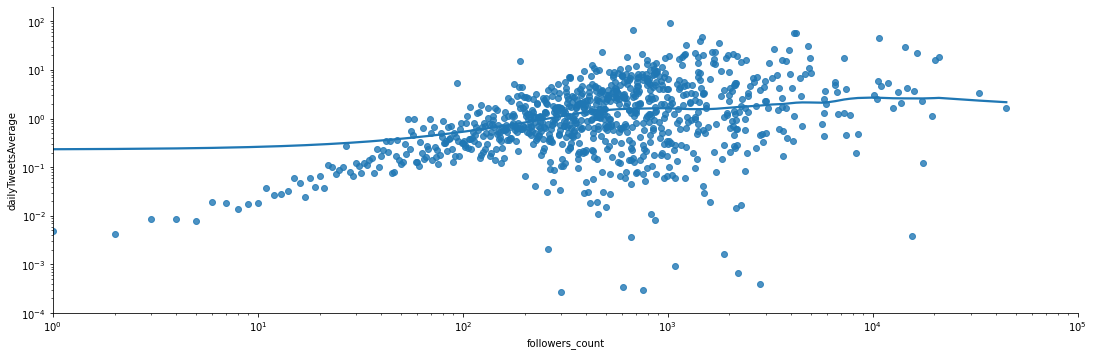

In [83]:
t = userProfileWithTimePandas.groupby("followers_count").mean().reset_index()
splot = sns.lmplot(x="followers_count", y="dailyTweetsAverage", data=t,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


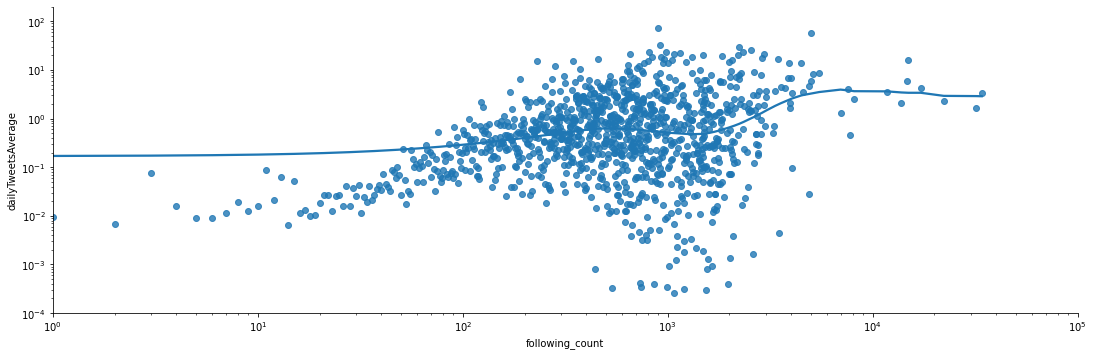

In [84]:
d = userProfileWithTimePandas.groupby("following_count").mean().reset_index()

splot = sns.lmplot(x="following_count", y="dailyTweetsAverage", data=d,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
plt.ylim(0.0001, 200)
plt.xlim(1, 100000)

 
plt.show()


In [85]:
followingCor = np.log(userProfileWithTimePandas["following_count"])
followersCor = np.log(userProfileWithTimePandas["followers_count"])
dailyTweetCor= np.log(userProfileWithTimePandas["dailyTweetsAverage"])
tweetCountCor = np.log(userProfileWithTimePandas["tweet_count"].astype(int))


data = {'DailyTweetsAverage':dailyTweetCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor1 = pd.DataFrame(data = data)
print(cor1.corr( method= 'pearson'))

data2 = {'TweetsCount':tweetCountCor , 'FollowersCount': followersCor, 'Following_count':followingCor }
cor2 = pd.DataFrame(data = data2)
print(cor2.corr( method= 'pearson'))

                    DailyTweetsAverage  FollowersCount  Following_count
DailyTweetsAverage            1.000000        0.749258         0.619394
FollowersCount                0.749258        1.000000         0.729187
Following_count               0.619394        0.729187         1.000000
                 TweetsCount  FollowersCount  Following_count
TweetsCount         1.000000        0.751906         0.615868
FollowersCount      0.751906        1.000000         0.729187
Following_count     0.615868        0.729187         1.000000


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [86]:
#join with dailyTweetsAverage
egoTimeline_merge=egoTimeline.merge(userProfileWithTimePandas[['id','dailyTweetsAverage']],
                                                                    left_on='user_id',right_on='id', how='inner')

In [87]:
egoTimeline_merge=egoTimeline_merge[~(egoTimeline_merge.user_mentions.isnull())]

In [88]:
#look at data
egoTimeline_merge.head()

,user_id,Twitter_id,user_mentions,id,dailyTweetsAverage
6,555533734,946100891953672192,555533734,555533734,0.40715
13,555533734,933960944195067904,555533734,555533734,0.40715
14,555533734,933944525726216192,555533734,555533734,0.40715
15,555533734,933944479106547714,555533734,555533734,0.40715
17,555533734,920034474347331584,864005090,555533734,0.40715


In [89]:
#count number of friends by user
a=egoTimeline_merge.groupby('user_id').agg({'user_mentions':lambda x: x.count(),'dailyTweetsAverage':lambda x: x.mean()}).reset_index()


In [90]:
a=a.drop_duplicates()

In [91]:
a.shape

(1153, 3)

In [92]:
a=a.rename({'user_mentions':'number of friends'},axis=1)

In [93]:
b=a.groupby('number of friends').dailyTweetsAverage.mean().reset_index()

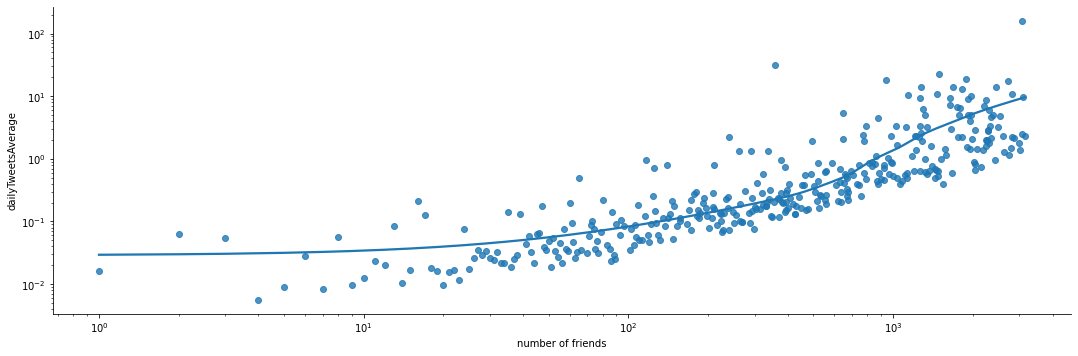

In [94]:
#plot 

splot = sns.lmplot(x="number of friends", y="dailyTweetsAverage", data=b,
           lowess=True,
           aspect=3)

splot.set(xscale = "log")
splot.set(yscale = "log")
# control x and y limits
"""plt.ylim(0.0001, 200)
plt.xlim(1, 100000)"""

 
plt.show()

In [95]:
c=b[['number of friends','dailyTweetsAverage']].apply(lambda x: np.log(x))

In [96]:
print(c.corr( method= 'pearson'))

                    number of friends  dailyTweetsAverage
number of friends            1.000000            0.845478
dailyTweetsAverage           0.845478            1.000000
